## UNET CNN

In [1]:
from ReadData import *
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
def readData(path, getTargetName = False):
    # print(getTargetName)
    data = getEMData(path)
    target = []
    field = []
    freq = []
    if getTargetName:
        targetName = []
        upper_case = [char for char in path if char.isupper()]
        target_name = path[path.index(upper_case[0]):path.index(upper_case[1])]

    for i in range(0, len(data)):
        target.append(data[i].target)
        field.append(data[i].Esct.real)
        freq.append(data[i].freq)
        if getTargetName: targetName.append(target_name)

    field = np.array(field)
    target = np.array(target)
    freq = np.array(freq)
    if getTargetName: targetName = np.array(targetName)

    result = (field, target, freq)
    if getTargetName: result = (field, target, freq, targetName)
    return result

In [3]:
fieldCirc, targetCirc, freqCirc, shapeCirc = readData(path = "./CircleData/", getTargetName=True)

fieldCirc_transformed = np.reshape(fieldCirc, (fieldCirc.shape[0], fieldCirc.shape[1], fieldCirc.shape[2], 1))
targetCirc_transformed = np.reshape(targetCirc, (targetCirc.shape[0], targetCirc.shape[1], targetCirc.shape[2], 1))

fieldCirc_train, fieldCirc_test, targetCirc_train, targetCirc_test, freqCirc_train, freqCirc_test= train_test_split(
    fieldCirc_transformed, targetCirc_transformed, freqCirc, test_size=0.20, random_state=42)


fieldCirc_train, fieldCirc_val, targetCirc_train, targetCirc_val= train_test_split(
    fieldCirc_train, targetCirc_train, test_size=0.20, random_state=42)

Read 300 samples


In [6]:
[fieldCirc_train.shape, targetCirc_train.shape, fieldCirc_test.shape, fieldCirc_val.shape]

[(192, 24, 24, 1), (192, 48, 48, 1), (60, 24, 24, 1), (48, 24, 24, 1)]

In [8]:
fieldMNIST, targetMNIST, freqMNIST = readData(path = "./MNIST_UNET/", getTargetName=False)

fieldMNIST_transformed = np.reshape(fieldMNIST, (fieldMNIST.shape[0], fieldMNIST.shape[1], fieldMNIST.shape[2], 1))
targetMNIST_transformed = np.reshape(targetMNIST, (targetMNIST.shape[0], targetMNIST.shape[1], targetMNIST.shape[2], 1))

fieldMNIST_train, fieldMNIST_test, targetMNIST_train, targetMNIST_test= train_test_split(
    fieldMNIST_transformed, targetMNIST_transformed, test_size=0.20, random_state=42)

fieldMNIST_train, fieldMNIST_val, targetMNIST_train, targetMNIST_val= train_test_split(
    fieldMNIST_train, targetMNIST_train, test_size=0.20, random_state=42)

Read 520 samples


In [9]:
[fieldMNIST_train.shape,targetMNIST_train.shape, fieldMNIST_val.shape, targetMNIST_val.shape]

[(332, 24, 24, 1), (332, 35, 35, 1), (84, 24, 24, 1), (84, 35, 35, 1)]

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation, Input, Concatenate, AveragePooling2D,Add, Cropping2D

In [30]:
def unet_for_mnist(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(256, 3, padding='same')(pool2)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)
    bottleneck = Conv2D(256, 3, padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    # Expansive Path
    up1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    skip1 = Concatenate(axis=-1)([conv2, up1])
    conv3 = Conv2D(128, 3, padding='same')(skip1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv3)
    skip2 = Concatenate(axis=-1)([conv1, up2])
    conv4 = Conv2D(64, 3, padding='same')(skip2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(64, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    up3 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(conv4)
    # skip2 = Concatenate(axis=-1)([conv1, up2])
    conv5 = Conv2D(32, 3, padding='same')(up3)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(32, 3, padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    # Cropping to the desired size (35, 35)
    cropped_output = Cropping2D(((7, 6), (7, 6)))(output)
    # skip3 = Concatenate(axis=-1)([input, cropped_output])


    model = Model(inputs=inputs, outputs=cropped_output)

    return model

In [31]:
inputMNIST_shape = fieldMNIST_train.shape[1:]
model_mnist = unet_for_mnist(inputMNIST_shape)
model_mnist.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 24, 24, 1)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 24, 24, 64)   640         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_26 (BatchN  (None, 24, 24, 64)  256         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_26 (Activation)     (None, 24, 24, 64)   0           ['batch_normalization_26[0]

In [13]:
from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

Train on MNIST then test on shape (freq 1e9 and permitivity 2)

In [14]:
init_lr = 1e-3
final_lr = 1e-8
total_epoch = 200

In [51]:


def log_learning_rate(num_epoch):
    return np.logspace(np.log10(init_lr), np.log10(final_lr), num=num_epoch, endpoint=True)

def lr_scheduler(epoch, lr):
    return log_learning_rate(total_epoch)[epoch]

earlyStop = EarlyStopping(monitor='loss',patience=3)

# def SGD_opt(model):
#     lr_callback = LearningRateScheduler(lr_scheduler)
#     optimizer = tf.keras.optimizers.SGD(learning_rate=init_lr, momentum=0.99)
#     model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = 'accuracy')
#     return model.fit(x = fieldMNIST_train, y = targetMNIST_train, batch_size = 1, epochs = total_epoch, 
#                      callbacks = [lr_callback, EarlyStopping(monitor='loss',patience=3)])#stop when seeing no loss change in 3 consecutive epochs


In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

checkpoint = tf.keras.callbacks.ModelCheckpoint("./model_weights/", 
                    monitor="loss", mode="min", 
                    save_best_only=True, verbose=1)

earlyStop = EarlyStopping(monitor='loss',patience=5)


model_mnist.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = 'accuracy')
model_mnist.fit(x = fieldMNIST_train, y = targetMNIST_train, validation_data=(fieldMNIST_val, targetMNIST_val), batch_size = 20, epochs = total_epoch, 
               callbacks = [earlyStop])

Epoch 1/200
17/17 [==============================] - 8s 385ms/step - loss: 0.1071 - accuracy: 0.8906 - val_loss: 0.2271 - val_accuracy: 0.9575
Epoch 2/200
17/17 [==============================] - 6s 336ms/step - loss: 0.0458 - accuracy: 0.9357 - val_loss: 0.1464 - val_accuracy: 0.9573
Epoch 3/200
17/17 [==============================] - 6s 346ms/step - loss: 0.0421 - accuracy: 0.9380 - val_loss: 0.1083 - val_accuracy: 0.9493
Epoch 4/200
17/17 [==============================] - 6s 367ms/step - loss: 0.0408 - accuracy: 0.9395 - val_loss: 0.0955 - val_accuracy: 0.9503
Epoch 5/200
17/17 [==============================] - 7s 414ms/step - loss: 0.0385 - accuracy: 0.9405 - val_loss: 0.0916 - val_accuracy: 0.9502
Epoch 6/200
17/17 [==============================] - 7s 401ms/step - loss: 0.0376 - accuracy: 0.9412 - val_loss: 0.0873 - val_accuracy: 0.9508
Epoch 7/200
17/17 [==============================] - 7s 410ms/step - loss: 0.0370 - accuracy: 0.9417 - val_loss: 0.0796 - val_accuracy: 0.9503

In [37]:
from keras.models import save_model
save_model(model_mnist, 'model_mnist.h5')


In [38]:
from keras.models import load_model

# Load the model
loaded_model = load_model('model_mnist.h5')

# Now, you can use the loaded model for prediction or further training
predictions = loaded_model.predict(fieldMNIST_test)

4/4 [==============================] - 1s 92ms/step


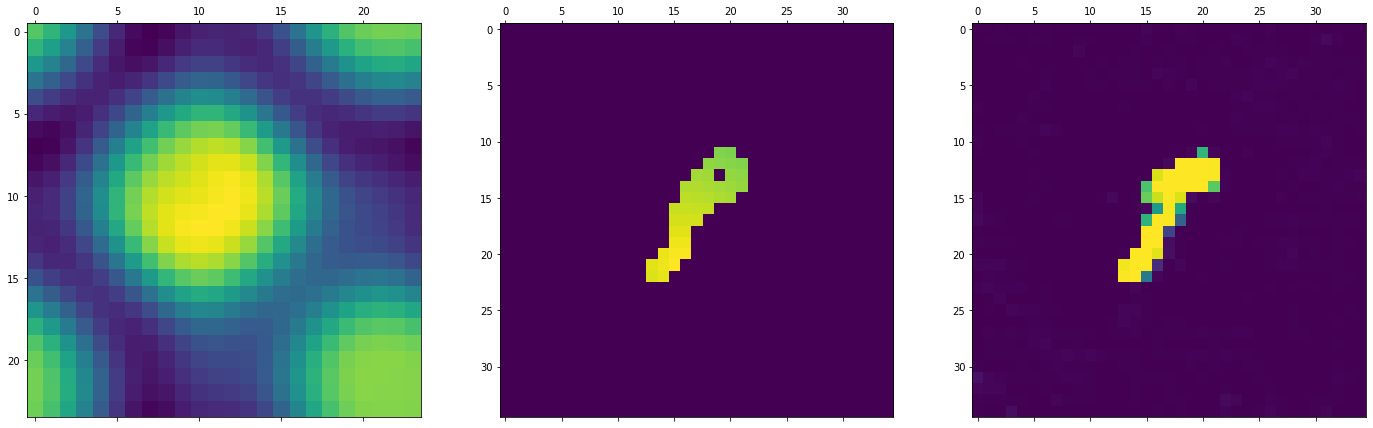

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[2])
axs[1].matshow(targetMNIST_test[2])
axs[2].matshow(predictions[2])

plt.show()

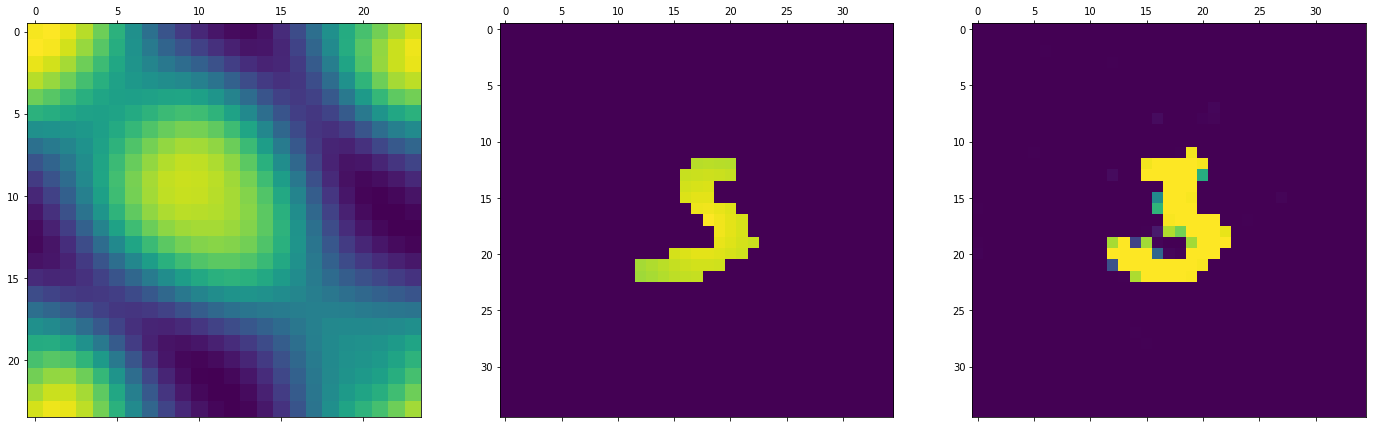

In [18]:
# fig, axs = plt.subplots(1, 3, figsize=(24, 24))

# axs[0].matshow(fieldMNIST_test[1])
# axs[1].matshow(targetMNIST_test[1])
# axs[2].matshow(pred1[1])

# plt.show()

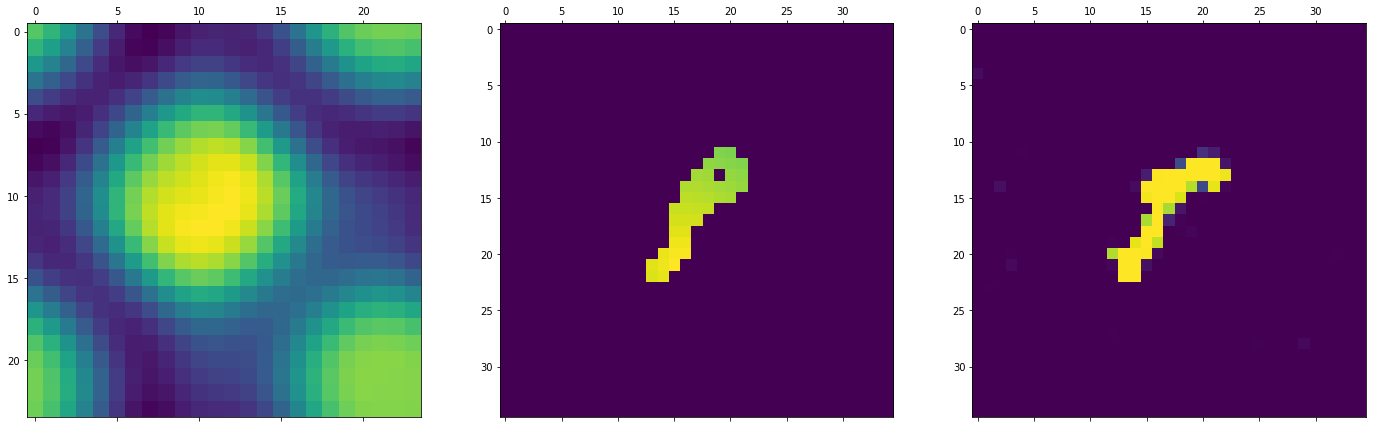

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[2])
axs[1].matshow(targetMNIST_test[2])
axs[2].matshow(pred1[2])

plt.show()

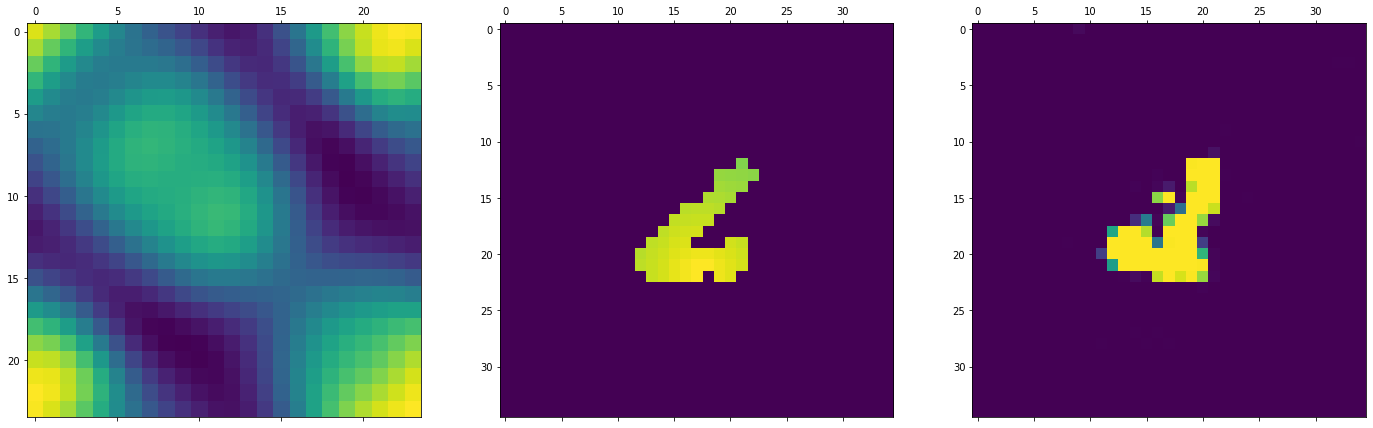

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[3])
axs[1].matshow(targetMNIST_test[3])
axs[2].matshow(pred1[3])

plt.show()

In [19]:
pred2 = model_mnist.predict(fieldCirc_test)

2/2 [==============================] - 0s 120ms/step


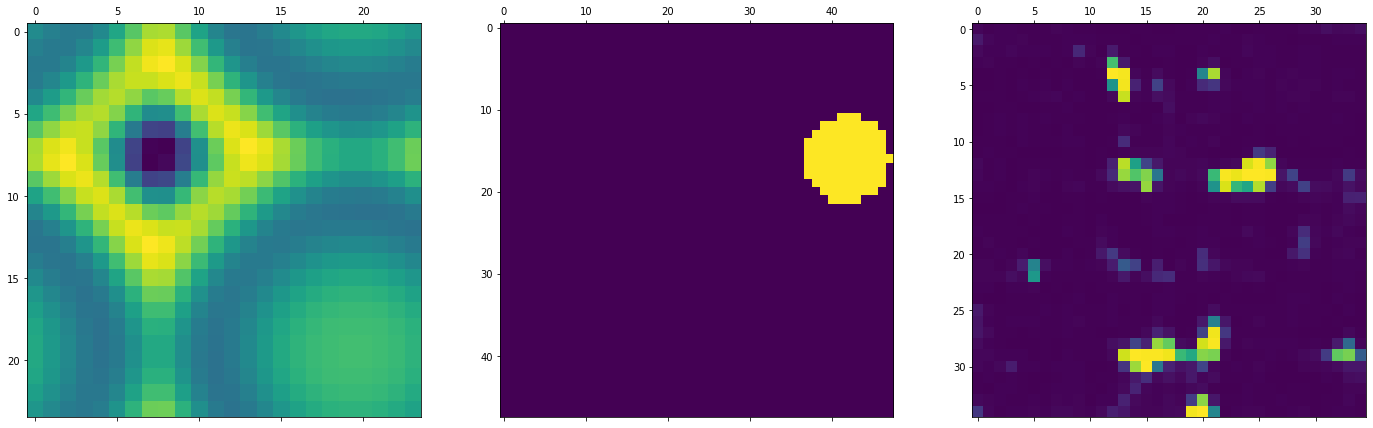

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldCirc_test[1])
axs[1].matshow(targetCirc_test[1])
axs[2].matshow(pred2[1])

plt.show()

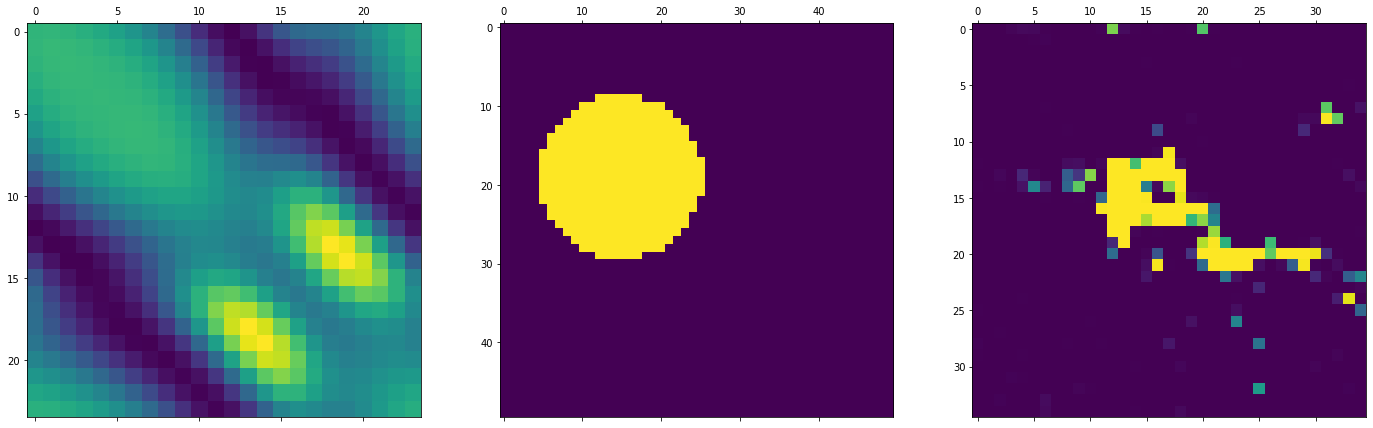

In [24]:
# fig, axs = plt.subplots(1, 3, figsize=(24, 24))

# axs[0].matshow(fieldCirc_test[1])
# axs[1].matshow(targetCirc_test[1])
# axs[2].matshow(pred2[1])

# plt.show()

Train with shape data 

In [21]:
def unet_for_shape(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(256, 3, padding='same')(pool2)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)
    bottleneck = Conv2D(256, 3, padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    # Expansive Path
    up1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    skip1 = Concatenate(axis=-1)([conv2, up1])
    conv3 = Conv2D(128, 3, padding='same')(skip1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv3)
    skip2 = Concatenate(axis=-1)([conv1, up2])
    conv4 = Conv2D(64, 3, padding='same')(skip2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(64, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    up3 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(conv4)
    # skip2 = Concatenate(axis=-1)([conv1, up2])
    conv5 = Conv2D(32, 3, padding='same')(up3)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(32, 3, padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    # conv5 = Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same')(conv4)

    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    # Cropping to the desired size (35, 35)
    # cropped_output = Cropping2D(((7, 6), (7, 6)))(output)

    model = Model(inputs=inputs, outputs=output)

    return model

In [22]:
inputCirc_shape = fieldCirc_train.shape[1:]
model_shape = unet_for_shape(inputCirc_shape)
model_shape.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 24, 1)]  0           []                               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 24, 24, 64)   640         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_13 (BatchN  (None, 24, 24, 64)  256         ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 24, 24, 64)   0           ['batch_normalization_13[0]

In [23]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)
model_shape.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = 'accuracy')
model_shape.fit(x = fieldCirc_train, y = targetCirc_train, validation_data=(fieldCirc_val, targetCirc_val), batch_size = 20, epochs = total_epoch, 
               callbacks = [EarlyStopping(monitor='loss',patience=5)])

Epoch 1/200
10/10 [==============================] - 7s 458ms/step - loss: 0.1294 - accuracy: 0.8371 - val_loss: 0.8270 - val_accuracy: 0.1607
Epoch 2/200
10/10 [==============================] - 4s 375ms/step - loss: 0.0705 - accuracy: 0.9040 - val_loss: 0.7962 - val_accuracy: 0.1753
Epoch 3/200
10/10 [==============================] - 4s 375ms/step - loss: 0.0597 - accuracy: 0.9198 - val_loss: 0.6164 - val_accuracy: 0.3232
Epoch 4/200
10/10 [==============================] - 4s 374ms/step - loss: 0.0538 - accuracy: 0.9277 - val_loss: 0.7780 - val_accuracy: 0.2107
Epoch 5/200
10/10 [==============================] - 4s 368ms/step - loss: 0.0429 - accuracy: 0.9426 - val_loss: 0.8360 - val_accuracy: 0.1619
Epoch 6/200
10/10 [==============================] - 4s 377ms/step - loss: 0.0417 - accuracy: 0.9429 - val_loss: 0.8122 - val_accuracy: 0.1793
Epoch 7/200
10/10 [==============================] - 4s 368ms/step - loss: 0.0412 - accuracy: 0.9427 - val_loss: 0.7285 - val_accuracy: 0.2475

In [24]:
pred3 = model_shape.predict(fieldCirc_test)

2/2 [==============================] - 1s 122ms/step


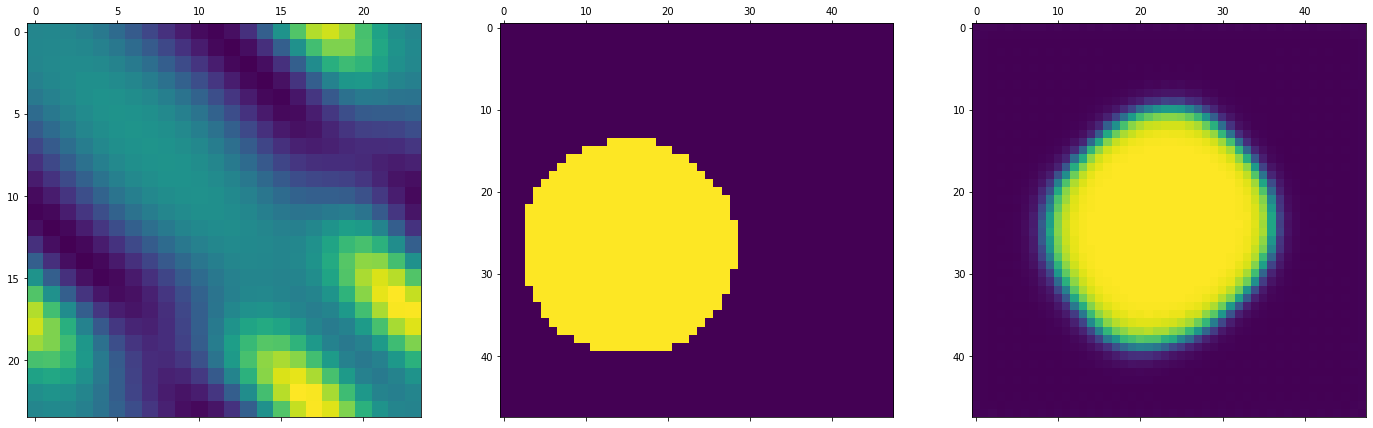

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldCirc_test[3])
axs[1].matshow(targetCirc_test[3])
axs[2].matshow(pred3[3])

plt.show()

In [28]:
pred4 = model_shape.predict(fieldMNIST_test)

4/4 [==============================] - 1s 111ms/step


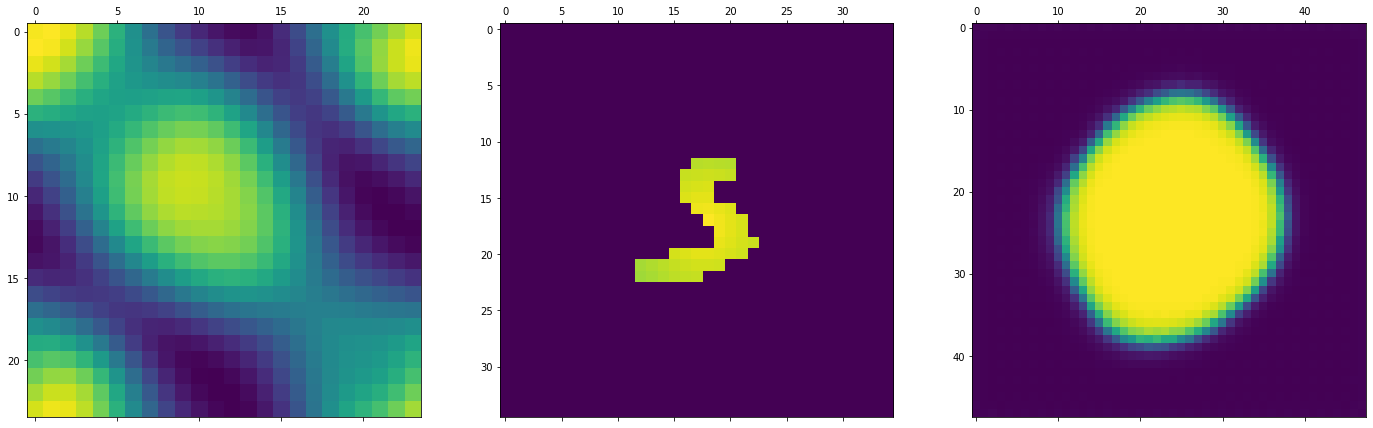

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[1])
axs[1].matshow(targetMNIST_test[1])
axs[2].matshow(pred4[1])

plt.show()